In [16]:
import random
import pandas as pd
from sklearn.cluster import DBSCAN
# from sklearn.cluster import SpectralClustering, AgglomerativeClustering, OPTICS, MeanShift # Not working

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Load list of API calls
API_LIST = "../api_calls.txt"
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split(',')
APIS.append(DELIMITER) #Add the label for NaN values.
API_FILE.close()

#Random Seed
seed = 1

def list_to_str(ls:list):
    '''Convert list to a stringified version (comma delimited).'''
    output = ""
    for l in ls:
        output += str(l) + ","
    return output[0:len(output)-1]

def load_df():
    '''Load the dataset file (CSV) as DataFrame'''
    print("Loading DF...")
    df = pd.read_csv("../oliveira.csv") # MAKE SURE THIS IS SET AS `oliveira.csv`
    df = df[df['malware'] == 1].copy()
    df = df.drop('malware', axis=1)
    print("")
    return df.reset_index().iloc[:,1:]

def get_x(df:pd.DataFrame):
    '''Get the feature columns of the DataFrame'''
    return df.iloc[:, 1:102-1]

#Inverse Label Encoding
def inverse_labeller(item):
    '''Low Level. Converts encoded API calls to string API calls'''
    global APIS
    return item.map(lambda x: APIS[int(x)])
def inverse_label(df:pd.DataFrame):
    '''High Level. Converts encoded API calls to string API calls'''
    df2 = df.copy(deep=True)
    print("Inverse Labelling...")
    df2.iloc[:, 1:101] = df2.iloc[:, 1:101].apply(inverse_labeller, axis=1, result_type='reduce')
    print("")
    return df2

def inject_patterns(inner_df:pd.DataFrame, inverse_labelled_df:pd.DataFrame):
    '''Injects the API call patterns of each sample as its last column'''
    patterns = []
    print("Injecting API patterns...")
    for row in range(inner_df.shape[0]):
        patterns.append(list_to_str(inverse_labelled_df.iloc[row,1:101].transpose().to_list()))
    inner_df['pattern'] = patterns
    print("")
    inverse_label(inner_df).to_csv(f"Clustering/Malicious/API_Patterns.csv", index=False)
    return inner_df

def common_api_cluster(inner_df:pd.DataFrame, name:str):
    '''Determine the most common API call patterns for each cluster'''
    global df
    inner_df = df
    clusters = inner_df['cluster'].unique()
    clusters.sort()
    commonAPI = []
    print("Searching for Common API Patterns per Cluster...")
    print(clusters)
    for cluster in clusters:
        raw_commonC = inner_df[inner_df['cluster']==cluster]['pattern']#.value_counts()
        commonC = raw_commonC.value_counts().to_frame(name='counts').reset_index()
        commonAPI.append([cluster, commonC['counts'].iloc[0], round(commonC['counts'].iloc[0]/raw_commonC.shape[0],4), commonC['pattern'].iloc[0]])
    commonAPI = pd.DataFrame(commonAPI, columns=['cluster', 'count', 'match_ratio', 'pattern'])
    commonAPI.to_csv(f"Clustering/Malicious/Manual_{name}_Common_API_Cluster.csv", index=False)
    print("")
    print("Average Match Ratio:", commonAPI['match_ratio'].mean())
    return commonAPI

def get_samplehash_common(inner_df:pd.DataFrame, common_counts:pd.DataFrame, name:str, samplesize:int):
    '''Get sample hashes from each cluster that matches the common API call pattern of the cluster.'''
    hashes = []
    # global seed
    # random.seed(seed)
    # matching_samples = 0
    # print(f"Random (Seed @ {seed}) Sampling Hashes subset of  Most Common API Patterns...")
    # for pattern in range(common_counts.shape[0]):
    #     sub_df = inner_df[inner_df['pattern']==common_counts.iloc[pattern,3]]
    #     subsamples = len(sub_df['hash'].to_list())
    #     matching_samples += subsamples
    #     if subsamples < samplesize:
    #         subsamples = random.sample(sub_df['hash'].to_list(), len(sub_df['hash'].to_list()))
    #     else:
    #         subsamples = random.sample(sub_df['hash'].to_list(), samplesize)
    #     for subsample in subsamples:
    #         hashes.append([common_counts.iloc[pattern,:]['cluster'], subsample, '_', '_', '_', common_counts.iloc[pattern,:]['pattern']])
    for i in range(inner_df.shape[0]):
        hashes.append([inner_df.iloc[i,:]['cluster'], inner_df.iloc[i,:]['hash'], '_', '_', '_', inner_df.iloc[i,:]['pattern']])
    hashes = pd.DataFrame(hashes, columns=['cluster', 'hash', 'Type 1', 'Type 2', 'Type 3', 'pattern'])
    hashes.to_csv(f"Clustering/Malicious/Manual_{name}_SampleHash_Common.csv", index=False)
    # print(f"Commonality Ratio: {(matching_samples/inner_df.shape[0])}")
    print("")
    return hashes

In [17]:
df = load_df()
print(df.shape)


Loading DF...

(42797, 101)


In [18]:
df = inject_patterns(df.copy(), inverse_label(df.copy()))
reserve_df = df.copy()
display(df.shape)

Inverse Labelling...

Injecting API patterns...

Inverse Labelling...



(42797, 102)

In [19]:
dbscan = DBSCAN(algorithm='auto', n_jobs=-1, min_samples=5)

X = get_x(df)
dbscan.fit(X)

DBSCAN(n_jobs=-1)

cluster
-1      14341
 0       3308
 5       1116
 59      1094
 14      1059
 81       863
 21       802
 11       738
 27       703
 22       698
 12       576
 31       539
 4        486
 16       485
 54       434
 13       411
 66       396
 139      367
 35       349
 8        344
Name: count, dtype: int64

<Axes: title={'center': 'Top 20 Clusters by Highest Sample Quantity'}, ylabel='cluster'>

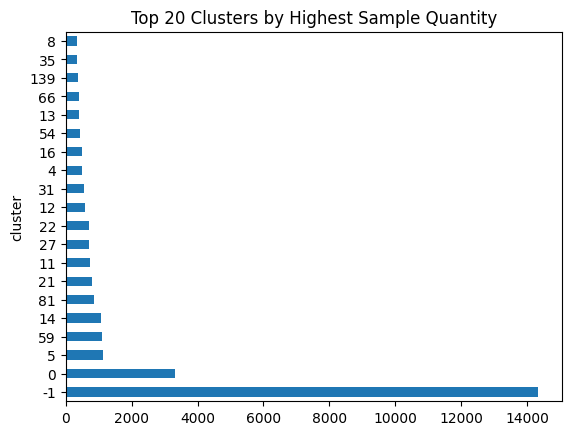

In [20]:
# TOP 10 CLUSTERS BY SAMPLE QUANTITY
df['cluster'] = dbscan.labels_
display(df['cluster'].value_counts()[0:20])
display(df['cluster'].value_counts()[0:20].plot(kind='barh',title='Top 20 Clusters by Highest Sample Quantity'))

cluster
298    5
159    5
156    5
417    5
425    5
146    5
144    5
434    5
441    5
442    5
266    5
447    5
129    5
457    5
459    5
412    5
461    5
470    5
483    5
486    5
Name: count, dtype: int64

<Axes: title={'center': 'Top 20 Clusters by Lowest Sample Quantity'}, ylabel='cluster'>

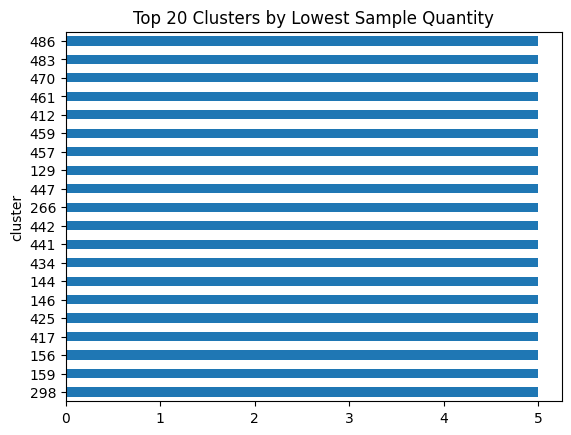

In [21]:
display(df['cluster'].value_counts(ascending=True)[0:20])
display(df['cluster'].value_counts(ascending=True)[0:20].plot(kind='barh',title='Top 20 Clusters by Lowest Sample Quantity'))

In [22]:
df.to_csv(f"./Clustering/Malicious/Manual_DBSCAN_Clustering.csv", index=False)

In [23]:
df = inverse_label(df)
df.to_csv(f"./Clustering/Malicious/Manual_DBSCAN_Encoded_Clustering.csv", index=False)

Inverse Labelling...



In [24]:
commonAPI = common_api_cluster(df, "DBSCAN")
display(commonAPI)

commonHashes = get_samplehash_common(df, commonAPI, "DBSCAN", 99999)
display(commonHashes)

Searching for Common API Patterns per Cluster...
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 2

,cluster,count,match_ratio,pattern
0,-1,4,0.0003,"NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOp..."
1,0,3308,1.0000,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos..."
2,1,128,1.0000,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor..."
3,2,8,1.0000,"SetUnhandledExceptionFilter,OleInitialize,LdrL..."
4,3,173,1.0000,"NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOp..."
...,...,...,...,...
595,594,7,1.0000,"GetShortPathNameW,LdrGetDllHandle,LdrLoadDll,G..."
596,595,5,1.0000,"NtAllocateVirtualMemory,SetErrorMode,LoadStrin..."
597,596,5,1.0000,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos..."
598,597,6,1.0000,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."


,cluster,hash,Type 1,Type 2,Type 3,pattern
0,0,071e8c3f8922e186e57548cd4c703a5d,_,_,_,"RegOpenKeyExA,NtOpenKey,NtQueryValueKey,NtClos..."
1,1,33f8e6d08a6aae939f25a8e0d63dd523,_,_,_,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor..."
2,2,b68abd064e975e1c6d5f25e748663076,_,_,_,"SetUnhandledExceptionFilter,OleInitialize,LdrL..."
3,-1,72049be7bd30ea61297ea624ae198067,_,_,_,"GetSystemTimeAsFileTime,NtAllocateVirtualMemor..."
4,-1,c9b3700a77facf29172f32df6bc77f48,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
...,...,...,...,...,...,...
42792,11,e3d6d58faa040f0f9742c9d0eaf58be4,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
42793,-1,9b917bab7f32188ae40c744f2be9aaf8,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
42794,-1,35a18ee05f75f04912018d9f462cb990,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
42795,11,654139d715abcf7ecdddbef5a84f224b,_,_,_,"GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProce..."
